In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

### Bring in data

In [2]:
df_filled = pd.read_csv('data/missoula_valley_wells_imputed_qreg.csv')
df_pump = pd.read_csv('data/mso_monthly_pumping_rates.csv')
df_static = pd.read_csv('data/static_variables.csv')

q = df_filled[['time','Q']]
q.set_index('time', inplace=True)
q.index = pd.to_datetime(q.index)

### Seasonal decomposition with LOESS

In [3]:
stl = STL(q, seasonal=13, robust=True)
res = stl.fit()

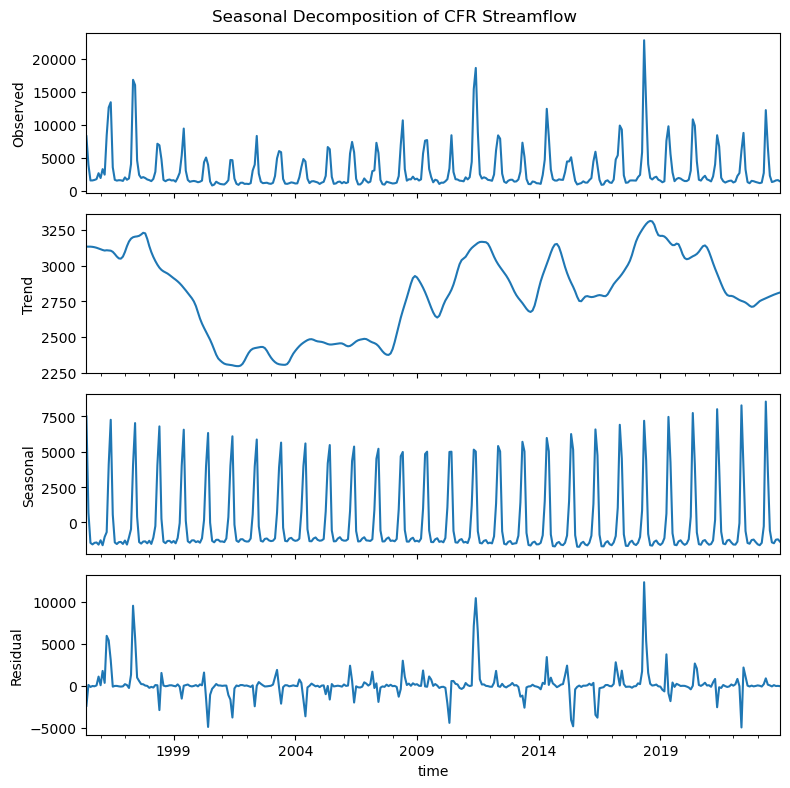

In [4]:
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
res.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
res.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
res.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
res.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
fig.tight_layout()
fig.suptitle('Seasonal Decomposition of CFR Streamflow')
fig.subplots_adjust(top=0.95)
plt.show()



### Trend analysis

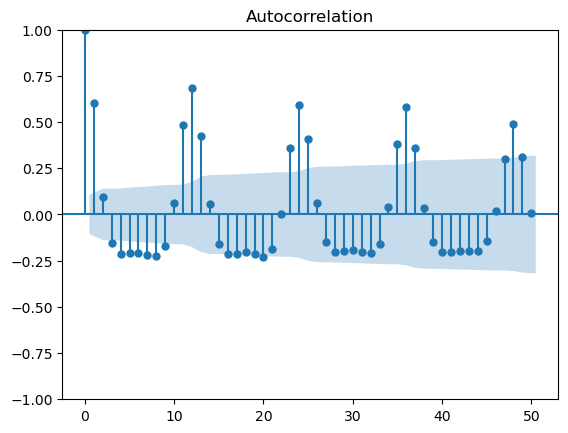

In [5]:
sm.graphics.tsa.plot_acf(q, lags=50)
plt.show()

In [6]:
# There is strong seasonal autocorrelation so we use the seasonal Mann-Kendall test. 
# This test looks for trends across the seasons, rather than across the entire time series.
# This test assumes that the trends across seasons are in the same direction, otherwise 
# the test may not be valid. 
mk_full = mk.seasonal_test(q, period=12)
mk_first7 = mk.seasonal_test(q['1995-06-30' : '2002-06-30'], period=12)
mk_last21 = mk.seasonal_test(q['2002-06-30' : '2023-06-30'], period=12)

print(f"The trend in the full timeseries is {mk_full.slope:.3f} (cfs/mo) with a p-value of {mk_full.p:.3f}")
print(f"The trend in the first seven years is {mk_first7.slope:.3f} (cfs/mo) with a p-value of {mk_first7.p:.3e}")
print(f"The trend in the last 21 years is {mk_last21.slope:.3f} (cfs/mo) with a p-value of {mk_last21.p:.3e}")


The trend in the full timeseries is 6.132 (cfs/mo) with a p-value of 0.079
The trend in the first seven years is -192.000 (cfs/mo) with a p-value of 2.174e-12
The trend in the last 21 years is 19.091 (cfs/mo) with a p-value of 1.019e-05


In [7]:
# In case the trends are not consistent across seasons, we can look at the trends in the
# decomposed trend component.
mk_full_t = mk.original_test(res.trend)
mk_first7_t = mk.original_test(res.trend['1995-06-30' : '2002-06-30'])
mk_last21_t = mk.original_test(res.trend['2002-06-30' : '2023-06-30'])

print(f"The trend in the full timeseries is {mk_full_t.slope:.3f} (cfs/mo) with a p-value of {mk_full_t.p:.3e}")
print(f"The trend in the first seven years is {mk_first7_t.slope:.3f} (cfs/mo) with a p-value of {mk_first7_t.p:.3e}")
print(f"The trend in the last 21 years is {mk_last21_t.slope:.3f} (cfs/mo) with a p-value of {mk_last21_t.p:.3e}")

The trend in the full timeseries is 1.059 (cfs/mo) with a p-value of 5.359e-07
The trend in the first seven years is -12.556 (cfs/mo) with a p-value of 0.000e+00
The trend in the last 21 years is 2.774 (cfs/mo) with a p-value of 0.000e+00


### Seasonal trend analysis

In [8]:
q = q.assign(season = q.index.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}))

q_seas = q.groupby('season').resample('Y')['Q'].mean().reset_index(['season'])

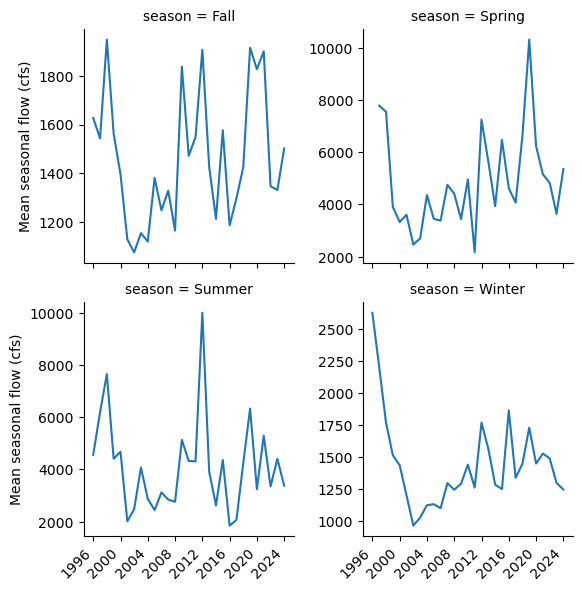

In [9]:
# Create the FacetGrid plot
g = sns.FacetGrid(q_seas.reset_index(), col='season', col_wrap=2, sharey=False, sharex=True)
g.map(sns.lineplot, 'time','Q')
g.set_ylabels('Mean seasonal flow (cfs)')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

In [10]:
# Look for trends in last 21 years of seasonal data
date_slice = slice('2002-12-31', '2023-12-31')
mk_seas_w = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Winter').dropna()[date_slice])
mk_seas_sp = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Spring').dropna()[date_slice])
mk_seas_su = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Summer').dropna()[date_slice])
mk_seas_f = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Fall').dropna()[date_slice])

print(f"The trend in Winter timeseries is {mk_seas_w.slope:.3f} (cfs/mo) with a p-value of {mk_seas_w.p:.3e}")
print(f"The trend in Spring timeseries is {mk_seas_sp.slope:.3f} (cfs/mo) with a p-value of {mk_seas_sp.p:.3e}")
print(f"The trend in Summer timeseries is {mk_seas_su.slope:.3f} (cfs/mo) with a p-value of {mk_seas_su.p:.3e}")
print(f"The trend in Fall timeseries is {mk_seas_f.slope:.3f} (cfs/mo) with a p-value of {mk_seas_f.p:.3e}")

The trend in Winter timeseries is 18.597 (cfs/mo) with a p-value of 8.035e-03
The trend in Spring timeseries is 106.667 (cfs/mo) with a p-value of 3.211e-02
The trend in Summer timeseries is 26.481 (cfs/mo) with a p-value of 3.669e-01
The trend in Fall timeseries is 13.185 (cfs/mo) with a p-value of 5.518e-02


### Annual max trend analysis

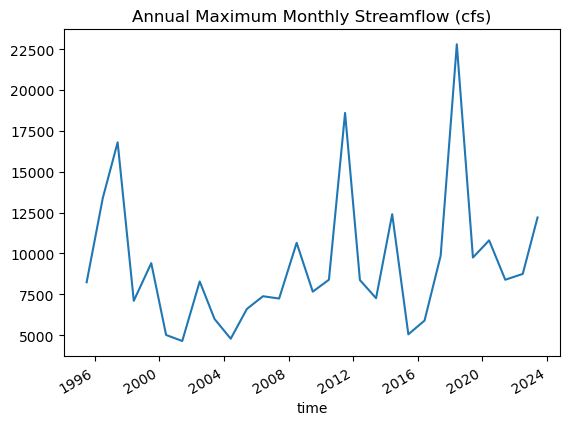

In [11]:
q.loc[:, 'year'] = q.reset_index().time.dt.year.values
q.loc[:, 'month'] = q.reset_index().time.dt.month.values
q.loc[:, 'year'] = q.loc[:, 'year'].astype(int)
q.loc[:, 'month'] = q.loc[:, 'month'].astype(int)
q_max = q.loc[q.groupby('year')['Q'].idxmax()]
q_max['Q'].plot()
plt.title('Annual Maximum Monthly Streamflow (cfs)')
plt.show()

In [13]:
mk_qmax = mk.original_test(q_max['Q'].loc[q_max['year'] > 2001])
print(f"The trend in annual max flow is {mk_qmax.slope:.3f} (cfs/yr) with a p-value of {mk_qmax.p:.3e}")

The trend in annual max flow is 225.000 (cfs/yr) with a p-value of 1.921e-02
